# Python Looking Under the Hood 
**Julie**

## Brief Summary of Fluent python Study 

<img src="https://img.ridicdn.net/cover/2409002736/xxlarge" style="width:80px; height:100px;" align="left"/>


      - From Sep. 2019 To Jan 2020 (5 months) 
      - a day a weekday
      - 21 Chapters (almost 600 pages) 


- schedule table 

<img src="fluentpyschedule.png" style="width:400px;" >


- We summarized the study in our each ways.


### Part1 Prologue
#### CH1.The Python Data Model

* 데이터 모델 : 일종의 프레임워크, 언어 자체의 구성단위에 대한 인터페이스를 공식적으로 정의한다. 


* Difference between __str__ and __repr__?

https://stackoverflow.com/questions/1436703/difference-between-str-and-repr

* Data Model reference 

https://docs.python.org/3/reference/datamodel.html


* python data model 이해하기

https://www.slideshare.net/dahlmoon/numpy-20160330

* 파이썬의 메타클래스란 무엇인가?

https://code.tutsplus.com/ko/tutorials/quick-tip-what-is-a-metaclass-in-python--cms-26016

https://blog.ionelmc.ro/2015/02/09/understanding-python-metaclasses/

* why python is slow

http://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/



# Why Python is Slow: Looking Under the Hood

http://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/

### what is cpython
https://stackoverflow.com/questions/17130975/python-vs-cpython

<img src=https://i.imgur.com/PJME67T.png style="width:550px">

source : https://indianpythonista.wordpress.com/2018/01/04/how-python-runs/

In [1]:
import dis
dis.dis('c = a + b')

  1           0 LOAD_NAME                0 (a)
              2 LOAD_NAME                1 (b)
              4 BINARY_ADD
              6 STORE_NAME               2 (c)
              8 LOAD_CONST               0 (None)
             10 RETURN_VALUE


## Why Python is Slow

### reason 1. Python is Dynamically Typed rather than Statically Typed


```c
/* C code */
int a = 1;
int b = 2;
int c = a + b;
```

```python
# python code
a = 1
b = 2
c = a + b
```

#### C Code 

1. Assign <int> 1 to a
2. Assign <int> 2 to b
3. call binary_add<int, int>(a, b)
4. Assign the result to c
    
#### Python Code    
    
1. Assign 1 to a

    - 1a. Set a->PyObject_HEAD->typecode to integer
    - 1b. Set a->val = 1
    

2. Assign 2 to b

    - 2a. Set b->PyObject_HEAD->typecode to integer<br>
    - 2b. Set b->val = 2
    

3. call binary_add(a, b)

    - 3a. find typecode in a->PyObject_HEAD <br>
    - 3b. a is an integer; value is a->val<br>
    - 3c. find typecode in b->PyObject_HEAD<br>
    - 3d. b is an integer; value is b->val<br>
    - 3e. call binary_add<int, int>(a->val, b->val)<br>
    - 3f. result of this is result, and is an integer.
    

4. Create a Python object c

    - 4a. set c->PyObject_HEAD->typecode to integer
    - 4b. set c->val to result

## reason 2. Python is interpreted rather than compiled

## reason 3. Python's object model can lead to inefficient memory access

<img src=http://jakevdp.github.io/images/array_vs_list.png style="width:550px"/>

# Digging into Python

##  Integers

In [2]:
import sys
print(sys.version[:5])

3.6.8


In [3]:
x = 42
x

42

In [4]:
import ctypes

 
https://hg.python.org/cpython/file/3.4/Include/object.h#l105

```c
struct _longobject{
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};```

In [47]:
class IntStruct(ctypes.Structure):
    _fields_ = [("ob_ref", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong),
                ("ob_digit", ctypes.c_long),
               ]
    
    def __repr__(self):
        return ("IntStruct(ob_digit={self.ob_digit}, refcount={self.ob_ref})").format(self=self)

In [48]:
num = 42
IntStruct.from_address(id(42))

IntStruct(ob_digit=42, refcount=40)

In [49]:
id(42)

10915808

In [50]:
Istruct = IntStruct.from_address(id(42))
Istruct.ob_type, Istruct.ob_size, Istruct.ob_digit

(10277248, 1, 42)

Text(0, 0.5, 'reference count')

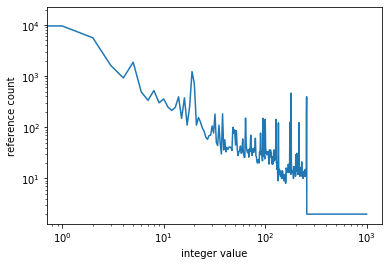

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
plt.loglog(range(1000), [sys.getrefcount(i) for i in range(1000)])
plt.xlabel('integer value')
plt.ylabel('reference count')

## Lists

Let's apply the above ideas to a more complicated type: Python lists. 

Analogously to integers, we find the definition of the list object itself in [Include/listobject.h](https://hg.python.org/cpython/file/3.4/Include/listobject.h#l23)

```c
typedef struct{
    long ob_refcnt;
    PyTypeObject *ob_type;
    Pyssize_t ob_size;
    PyObject **ob_item;
    long allocated;    
}PyListObject;
```

In [52]:
class ListStruct(ctypes.Structure):
    _fields_ = [("ob_refcnt", ctypes.c_long),
                ("ob_type", ctypes.c_void_p),
                ("ob_size", ctypes.c_ulong), 
                ("ob_item", ctypes.c_long),# pyObject** pointer cast to long
                ("ob_digit", ctypes.c_long),
               ]
    
    def __repr__(self):
        return ("ListStruct(len={self.ob_size}, refcount={self.ob_refcnt} items={self.ob_item})").format(self=self)

In [53]:
L = [1,2,3,4,5]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=1 items=139668772431552)

In [54]:
tup = [L, L]
ListStruct.from_address(id(L))

ListStruct(len=5, refcount=3 items=139668772431552)

In [42]:
del L[4]

In [43]:
listStruct = ListStruct.from_address(id(L))
listStruct

ListStruct(len=4, refcount=3 items=139668773400784)

In [44]:
tup[1]

[1, 2, 3, 4]

In [45]:
# get a raw pointer to our list
Lstruct = ListStruct.from_address(id(L))

# create a type which is an array of integer pointers the same length as L
PtrArray = Lstruct.ob_size * ctypes.POINTER(IntStruct)

# instantiate this type using the ob_item pointer
L_values = PtrArray.from_address(Lstruct.ob_item)

In [46]:
[ptr[0] for ptr in L_values]  # ptr[0] dereferences the pointer

[IntStruct(ob_digit=1, refcount=9578, type=10277248, size=1),
 IntStruct(ob_digit=2, refcount=5626, type=10277248, size=1),
 IntStruct(ob_digit=3, refcount=1625, type=10277248, size=1),
 IntStruct(ob_digit=4, refcount=903, type=10277248, size=1)]

VISUALIZE CODE

http://pythontutor.com/

http://www.pythontutor.com/visualize.html


# Python Object and Type 

https://stackoverflow.com/questions/22921093/query-on-object-class-type-class-in-python

#### mlcore structure

<img src="mlcore-object.png">

#### python structure

<img src="https://i.stack.imgur.com/33Zt8.png">

In [4]:
print(isinstance(type,object))
print(type.__class__)
print(isinstance(object,type))

True
<class 'type'>
True


In [7]:
def function1():
    pass

isinstance(function1, object)

True

* Metaclass and DataModel 
https://www.slideshare.net/dahlmoon/numpy-20160330